# Using kmeans clustering to identify a small subset of labelled images to seed the classification process for Fashion MNIST dataset
## -Avirup Das [MDS202013]
## -Ayush Thada [MDS202014]

## Introduction

Clustering is usually used for problems related to unsupervised learning but we will use it as a pre-processing tool for semi-supervised learning. If we only have a few labels, we could perform clustering and propagate the labels to all the instances (or to the closest instances decided by percentile) in the same cluster. This technique can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

## Methodology

We will use logistic regression and a 7 layer deep neural network to classify the Fashion MNIST dataset. For each of these models we would first train the model with the whole data set (60000 instances) and test it for 10000 instances. The accuracy will be our baseline and we would try to improve upon that.<br>

|        Model        | Baseline Accuracy |
|:-------------------:|:-----------------:|
| Logistic Regression |       84.1%       |
|    Neural Network   |       89.68%      |


The Fashion MNIST dataset contains images of dimension $28\times28$, so as a pre-processing step for Logistic regression, we flatten the image matrix into a vector. We have also pickled our models so they can be re-used without retraining as we observed that the training time was very high since we were also experimenting with different values of the number of clusters. These files will be provided along with the code.

First we have created a pipeline that will cluster the training set into 100, 200 and 300 clusters and replace the images with their distances to these clusters, then apply a Logistic Regression model. 

| Cluster | Accuracy |
|:-------:|:--------:|
|   100   |  82.62%  |
|   200   |  83.89%  |
|   300   |  84.56%  |

Then we took random n-labelled instances (for n=500, 1000, 2000) and check how our models perform in terms of accuracy.

| Cluster | Logistic Regression | Neural Network |
|:-------:|:-------------------:|:--------------:|
|   500   |        78.52%       |     73.51%     |
|   1000  |        79.24%       |       76%      |
|   2000  |        80.89%       |     78.53%     |

We can see that the neural network does not perform very well compared to Logistic Regression in this case since we are using a very small amount of data as training set. On the other hand, the neural network takes much lesser time to get trained. We also see that the models perform better for large cluster sizes suggesting that for further experimentation we should work with large cluster sizes.<br>

Next, we cluster the instances into 2000 clusters and use the centroids to train our model.

| Cluster | Logistic Regression | Neural Network |
|:-------:|:-------------------:|:--------------:|
|   500   |          -          |      75.5%     |
|   1000  |          -          |     76.36%     |
|   2000  |        81.46%       |     80.24%     |

Again we see that the accuracy increases when the number of clusters is increased. Now we propagate the labels of these representative points (centroids) to all the instances under the same cluster and run our models.

| Cluster | Logistic Regression | Neural Network |
|:-------:|:-------------------:|:--------------:|
|   500   |          -          |     76.49%     |
|   1000  |          -          |     77.80%     |
|   2000  |        81.21%       |     79.90%     |


We do not see a significant difference between the results that is because when we have propagated the labels of the centroids to all instances, we have also included outliers or instances which are ambiguous in terms of which cluster they fall in. So let us propagate the labels to the instances which are close (25 percentile) to the cluster centroids an train our models again.

| Cluster | Logistic Regression | Neural Network |
|:-------:|:-------------------:|:--------------:|
|   500   |          -          |     75.98%     |
|   1000  |          -          |     77.34%     |
|   2000  |        80.44%       |     79.42%     |


Finally for 2000 clusters we try to find the optimum distance from the centroid (in terms of percentile) so as to achieve maximum accuracy.

| Percentile Distance | NN Accuracy |
|:-------------------:|:-----------:|
|          20         |     ~10%    |
|          25         |    79.42%   |
|          30         |    80.12%   |
|          50         |    80.12%   |
|          75         |    79.60%   |


We can see that the optimum distance is around 30-50th percentile after which the accuracy drops (from both ends of the range). It is to be noted that although we could not improve upon our baseline accuracy using semi-supervised learning techniques, but in a situation where we get completely unlabelled data, these techniques come handy for boosting the accuracy of our models after we have labelled a small but somewhat significant portion of the data manually.<br><br>
**Note that the accuracy scores for neural network may vary due to random initialisations or GPU configuration** <br><br>
Link to output folder: https://mega.nz/folder/QHhyADyK#1rk56JFrTMZ-RXJpjzXKAg

In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)

# Loading and Preprocessing Data

In [3]:
(X_train,y_train),(X_test,y_test)=datasets.fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']
# Normalizing
X_train, X_test= X_train/255.0, X_test/255.0

# Checking shape of the data
print(f"X-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

# Flattening data for Logistic Regression
X_train_flatten= X_train.reshape(X_train.shape[0],-1)
y_train_flatten= y_train.reshape(y_train.shape[0],-1)
X_test_flatten= X_test.reshape(X_test.shape[0],-1)
y_test_flatten= y_test.reshape(y_test.shape[0],-1)

X-train shape: (60000, 28, 28)
y-train shape: (60000,)
X-test shape: (10000, 28, 28)
y-test shape: (10000,)


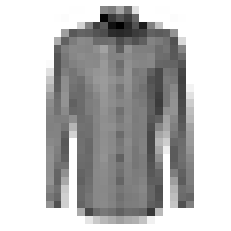

It is a  Shirt


In [4]:
index=3000
plt.imshow(X_train[index],cmap='binary')
plt.axis('off')
plt.show()

print('It is a ',class_names[y_train[index]])

# Experimenting with Logistic Regression

## On original data

In [5]:
%%time
%%memit
log_reg1 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg1.fit(X_train_flatten, y_train_flatten.ravel())

peak memory: 3220.67 MiB, increment: 0.00 MiB
CPU times: user 31min 35s, sys: 4.14 s, total: 31min 40s
Wall time: 31min 43s


In [9]:
dump(log_reg1,'log_reg_orig.joblib')
log_reg1.score(X_test_flatten, y_test_flatten)

0.841

In [16]:
%%time
%%memit
k=[100,200,300]
pipeline=np.empty(len(k),dtype=object)
for i in range(len(k)):
    pipeline[i] = Pipeline([("kmeans", KMeans(init='k-means++',n_clusters=k[i], random_state=seed)),
                         ("log_reg", LogisticRegression(multi_class="ovr", solver="saga",
                                                        max_iter=5000, random_state=seed))])
    pipeline[i].fit(X_train_flatten, y_train_flatten.ravel())
    dump(pipeline[i],'log_reg_kmeans_{}.joblib'.format(i))
    print('Cluster= {}, Accuracy= {}'.format(k[i],
            pipeline[i].score(X_test_flatten,y_test_flatten)))

Cluster= 100, Accuracy= 0.8262
Cluster= 200, Accuracy= 0.8389
Cluster= 300, Accuracy= 0.8456
peak memory: 6364.94 MiB, increment: 3626.22 MiB
CPU times: user 3h 16min 20s, sys: 2min 29s, total: 3h 18min 49s
Wall time: 2h 47min 38s


## Random Labelled Instances

In [17]:
%%time
%%memit
k=[500,1000,2000]
log_reg2=np.empty(len(k),dtype=object)
for i in range(len(k)):
    log_reg2[i] = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
    log_reg2[i].fit(X_train_flatten[:k[i]], y_train_flatten[:k[i]].ravel())
    dump(log_reg2[i],'log_reg_few_label_{}.joblib'.format(i))
    print('Labelled Instance= {}, Accuracy= {}'.format(k[i],
            log_reg2[i].score(X_test_flatten,y_test_flatten.ravel())))

Labelled Instance= 500, Accuracy= 0.7852
Labelled Instance= 1000, Accuracy= 0.7924
Labelled Instance= 2000, Accuracy= 0.8089
peak memory: 1732.44 MiB, increment: 7.16 MiB
CPU times: user 17.2 s, sys: 518 ms, total: 17.7 s
Wall time: 15 s


In [18]:
%%time
%%memit
kmeans1 = KMeans(init='k-means++',n_clusters=2000, random_state=seed)
X_items_dist = kmeans1.fit_transform(X_train_flatten)
dump(kmeans1,'kmeans_2000.joblib')
representative_items_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train_flatten[representative_items_idx]
y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')

peak memory: 10396.50 MiB, increment: 8859.62 MiB
CPU times: user 1h 32min 8s, sys: 7min 11s, total: 1h 39min 19s
Wall time: 16min 9s


In [22]:
y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')
print(np.array(class_names)[y_representative_items])

['Ankle Boot' 'T-shirt/top' 'T-shirt/top' ... 'Bag' 'Trouser' 'Ankle Boot']


## Using These Centroids to fit logistic regression

In [27]:
%%time
%%memit
log_reg3 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg3.fit(X_representative_items, y_representative_items)
dump(log_reg3,'log_reg_centroids.joblib')
print('Accuracy= ',log_reg3.score(X_test_flatten, y_test_flatten))

Accuracy=  0.8146
peak memory: 8181.33 MiB, increment: 0.03 MiB
CPU times: user 59.9 s, sys: 160 ms, total: 1min
Wall time: 1min


## Clustering and Propgating Labels to each Data Point

In [28]:
y_train_propagated = np.empty(len(X_train_flatten), dtype=np.int32)
for i in range(2000):
    y_train_propagated[kmeans1.labels_==i] = y_representative_items[i]

In [29]:
%%time
%%memit
log_reg4 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg4.fit(X_train_flatten, y_train_propagated)
dump(log_reg4,'log_reg_propagated.joblib')
print(log_reg4.score(X_test_flatten,y_test_flatten))

0.8121
peak memory: 8182.73 MiB, increment: 0.02 MiB
CPU times: user 32min 4s, sys: 3.96 s, total: 32min 8s
Wall time: 32min 11s


## Clustering and Propgating Labels to Data Points Closer to Cluster Centroids

In [31]:
%%time
%%memit
percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train_flatten)), kmeans1.labels_]
for i in range(2000):
    in_cluster = (kmeans1.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

peak memory: 3609.66 MiB, increment: 895.62 MiB
CPU times: user 264 ms, sys: 262 ms, total: 526 ms
Wall time: 646 ms


In [32]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [33]:
%%time
%%memit
log_reg5 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg5.fit(X_train_partially_propagated, y_train_partially_propagated)
dump(log_reg5,'log_reg_partially_propagated.joblib')
print(log_reg5.score(X_test_flatten,y_test_flatten))

0.8044
peak memory: 4021.36 MiB, increment: 0.03 MiB
CPU times: user 7min 15s, sys: 737 ms, total: 7min 16s
Wall time: 7min 16s


# Experimenting with Neural Networks

## Utility

In [4]:
def get_model(input_shape=(28,28, 1), n_class=10):
    model = models.Sequential([
                               layers.InputLayer(input_shape=input_shape),
                               layers.Conv2D(32, (3, 3), activation="relu"),
                               layers.Conv2D(64, (3, 3), activation="relu"),
                               layers.Conv2D(128, (3, 3), activation="relu"),
                               layers.Conv1D(1, 1, activation="relu"),
                               layers.Flatten(),
                               layers.Dense(64, activation='relu'),
                               layers.Dense(10, activation="sigmoid")
    ])

    model.compile(loss=losses.SparseCategoricalCrossentropy(name="loss"), 
                  optimizer="adam",
                  metrics=["accuracy"])
    
    return model

def train_model(model, x_data, y_data, patience=8, batch_size=32):
    estop = callbacks.EarlyStopping(patience=patience)
    history = model.fit(x_data[..., np.newaxis], 
                        y_data, 
                        batch_size = batch_size, 
                        epochs = 100,
                        verbose = 1,
                        validation_split = 0.1,
                        callbacks = [estop])
    return history.history

## On Original Data

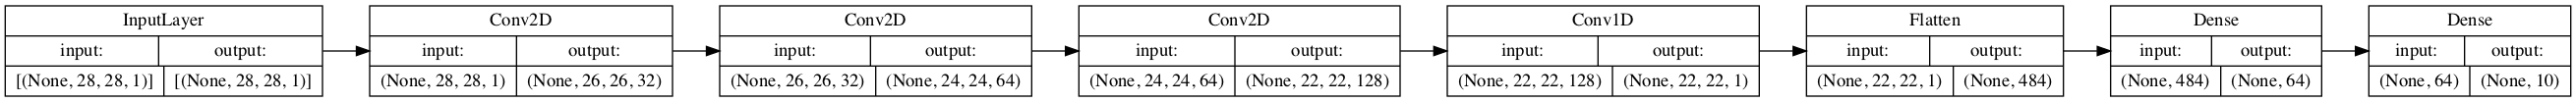

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1686/1688 [============================>.] - ETA: 0s - loss: 2.3028 - accuracy: 0.0969WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1695eb280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

In [12]:
%%time
%%memit

model_1 = get_model()
display(plot_model(model_1, rankdir="LR", show_shapes=True, show_layer_names=False))

# Train Model
history_1 = train_model(model_1, X_train, y_train);
# Testing Evaluation
model_1.evaluate(X_test[..., np.newaxis], y_test);
model_1.save('nn_original')

## Random Labelled Instances

In [21]:
%%time
%%memit

k=[500,1000,2000]
model_2,history_2=np.empty(len(k),dtype=object),np.empty(len(k),dtype=object)
for i in range(len(k)):
    model_2[i]=get_model()
    history_2[i]=train_model(model_2[i], X_train[:k[i]][..., np.newaxis], y_train[:k[i]])
    model_2[i].evaluate(X_test[..., np.newaxis], y_test);
    model_2[i].save('nn_labelled_{}'.format(k[i]))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/15 [=========================>....] - ETA: 0s - loss: 2.3027 - accuracy: 0.0873WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1695d2af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

# Clustering and Using Centroids as Representative

In [6]:
%%time
%%memit

k=[500,1000,2000]
kmeans_2=np.empty(len(k),dtype=object)
model_3,history_3=np.empty(len(k),dtype=object),np.empty(len(k),dtype=object)
for i in range(len(k)):
    kmeans_2[i] = KMeans(init='k-means++',n_clusters = k[i], random_state = seed)
    X_items_dist = kmeans_2[i].fit_transform(X_train.reshape(X_train.shape[0], -1))
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    X_representative_items = X_train[representative_items_idx]
    y_representative_items = y_train[representative_items_idx]
    
    model_3[i]=get_model()
    history_3[i]= train_model(model_3[i], X_representative_items[..., np.newaxis], y_representative_items)
    model_3[i].evaluate(X_test[..., np.newaxis], y_test);
    model_3[i].save('nn_centroid_cluster_{}'.format(k[i]))
    dump(kmeans_2[i],'cluster_nn_{}.joblib'.format(k[i]))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-17 11:08:23.291330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-17 11:08:23.293266: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - ETA: 0s - loss: 2.3030 - accuracy: 0.1300WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x15ea6e820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 1s 32ms/step - loss: 2.3029 - accuracy: 0.1306 - val_loss: 2.2993 - val_accuracy: 0.1600
Epoch 2/

2021-07-17 11:08:38.137924: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: nn_centroid_cluster_500/assets
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
28/29 [===========================>..] - ETA: 0s - loss: 1.8107 

## Clustering and Propgating Labels to each Data Point

In [12]:
def cluster_label_prop(k=500):
    kmeans=load('cluster_nn_{}.joblib'.format(k))
    X_items_dist=kmeans.transform(X_train.reshape(X_train.shape[0], -1))
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    X_representative_items = X_train[representative_items_idx]
    y_representative_items = y_train[representative_items_idx]
    y_train_propagated = np.empty(len(X_train), dtype=np.int32)
    for i in range(k):
        y_train_propagated[kmeans.labels_==i] = y_representative_items[i]
    
    #construct and train fresh neural network
    model_4=get_model()
    history_4 = train_model(model_4, X_train[..., np.newaxis], y_train_propagated)
    model_4.evaluate(X_test[..., np.newaxis], y_test);
    model_4.save('nn_full_propagated_{}'.format(k))

In [19]:
%%time
%%memit

for i in k:
    print('Clusters: ',i)
    cluster_label_prop(i)

Clusters:  500
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
426/427 [============================>.] - ETA: 0s - loss: 0.8639 - accuracy: 0.6846WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b551ff70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AU

## Clustering and Propgating Labels to Data Points Closer to Cluster Centroids

In [20]:
def cluster_label_prop(k=500,percentile_closest=25):
    kmeans=load('cluster_nn_{}.joblib'.format(k))
    X_items_dist=kmeans.transform(X_train.reshape(X_train.shape[0], -1))
    X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    y_representative_items = y_train[representative_items_idx]
    y_train_propagated = np.empty(len(X_train), dtype=np.int32)
    for i in range(k):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
        y_train_propagated[kmeans.labels_==i] = y_representative_items[i]
        
    # Allocating Labels to Marked Point in Cluster
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = X_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]
    
    #construct and train fresh neural network
    model_5=get_model()
    history_5 = train_model(model_5, X_train_partially_propagated[..., np.newaxis], y_train_partially_propagated)
    model_5.evaluate(X_test[..., np.newaxis], y_test);
    model_5.save('nn_partially_propagated_{}-clusters_{}-percentile'.format(k,percentile_closest))

In [18]:
%%time
%%memit

for i in k:
    print('Clusters: ',i)
    cluster_label_prop(i)

Clusters:  500
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
427/427 [==============================] - ETA: 0s - loss: 2.2991 - accuracy: 0.1121WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2c14d59d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AU

## Taking 2000 clusters and determining optimum percentile for propagation

In [22]:
%%time
%%memit

for i in [20,25,30,50,75]:
    print('Percentile= ',i)
    cluster_label_prop(k=2000,percentile_closest=i)

Percentile=  20
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
360/361 [============================>.] - ETA: 0s - loss: 2.3013 - accuracy: 0.1034WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2c14d5430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export A